# Sentiment Analysis and Melee Players

Super Smash Bros. Melee is a video game released in 2001 with a thriving competitive scene that persists even today. Twitter is the social media hub of choice for this community; almost every Top 100 ranked player actively tweets on Twitter, especially during the time around tournaments. 

Over time, stigmas develop around characters; the playerbase for some characters are perceived to complain more than others. I aim to perform sentiment analysis with VADER, a Natural Language Processing tool especially attuned to social media posts, to analyze the habits of Melee players and their tweets. 

In [1]:
import os
import snscrape.modules.twitter as sntwitter
import pandas as pd
import nltk #Need to download prior
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import datetime

Through a community effort, I produced a spreadsheet of Top 100 players and their Twitter username. The "Main" character that each player uses is included.

In [16]:
#Importing spreadsheet of twitter handles to loop through
players = pd.read_csv (r'C:\Users\Raymond Luu\Desktop\Liang\Melee-Twitter-Sentiment-Analysis\Melee Twitters.csv')

#Filtering out those without Twitters
players = players[~pd.isnull(players.Twitter)]

#Converting usernames to lowercase
players['Twitter'] = players['Twitter'].str.lower()
players

,Player,Main,Secondary,Twitter
0,Hungrybox,Jigglypuff,NaN,liquidhbox
1,Leffen,Fox,NaN,tsm_leffen
2,Mango,Falco,Fox,c9mang0
3,Axe,Pikachu,Falco,tempoaxe
4,Wizzrobe,Captain Falcon,NaN,wizzrobe
...,...,...,...,...
95,Schythed,Captain Falcon,NaN,schythed
96,Panda,Fox,NaN,brandonorooji
97,Soonsay,Fox,NaN,s00nsay
98,TheSWOOPER,Samus,NaN,theswooperr


# Scraping from Twitter
We then scrape up to 1000 Tweets from Twitter for each of the Top 100 players. We will remove Replies and Links to isolate original thoughts shared to their Tweet feed. The Twitter community started becoming most established after 2016 so that will be our starting year.

We end up with nearly 50,000 Tweets from this time period with which we could perform our analysis on.

In [2]:
#Scraping Twitter and returning a dataframe
def get_tweets(username,n=1000):
    output = []
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:'+username+' -filter:replies -filter:links since:2016-01-01').get_items()):
        if i == n:
            break
        output.append([tweet.date, tweet.content, tweet.user.username])
    return pd.DataFrame(output, columns=['Datetime', 'Text', 'Username'])

In [5]:
#Creating empty list which will be populated through our loop then concatenated
tweets = []

for user in players.Twitter:
    tweet_history = get_tweets(user,n=1000)
    tweets.append(tweet_history)
    
all_tweets = pd.concat(tweets)

#Converting to lowercase for easier joining
all_tweets['Username'] = all_tweets['Username'].str.lower()
all_tweets

,Datetime,Text,Username
0,2021-02-18 22:36:03+00:00,"Hi all,\n\nEarlier today I uploaded a video of...",liquidhbox
1,2021-02-12 19:18:39+00:00,anything is clutchable if you believe in yourself,liquidhbox
2,2021-02-08 03:14:39+00:00,tom brady is decent at football,liquidhbox
3,2021-02-07 04:01:05+00:00,what is a stalemate,liquidhbox
4,2021-01-08 06:29:21+00:00,my full time job is entering online smash tour...,liquidhbox
...,...,...,...
166,2017-07-09 10:46:13+00:00,I think @HS_Orange and @Powder_HS combined cr...,snowyhss
167,2017-04-29 23:07:01+00:00,"Played beyond awful in melee, idk how i can 3-...",snowyhss
168,2017-04-29 22:12:57+00:00,I hugged @C9Mang0 after our set PogChamp,snowyhss
169,2017-04-29 17:44:45+00:00,Im 5-2 in Hearthstone Grand with a lead over H...,snowyhss


# VADER
VADER (Valence Aware Dictionary and sEntiment Reasoner is a pre-trained model tuned to social media. It evaluates polarity of text and intensity as well. 

For the purposes of this study, we will focus on Compound score, which is VADER's unidimensional measure of sentiment. The [documentation](https://github.com/cjhutto/vaderSentiment) also provides threshold values to categorize a message as Positive, Neutral, or Negative.

In [6]:
#Creating functions to attach VADER's polarity scores to a player's tweet history
sid = SIA()

#use 'pos', 'neu', 'neg', 'compound' for value
def get_polarity_val(df,value):
    return sid.polarity_scores(df.Text)[value]

#Using thresholds as recommended by VADER's documentation
def classify(df):
    if df.compound > 0.05:
        return 'positive'
    elif df.compound < -0.05:
        return 'negative'
    else:
        return 'neutral'

#Adding all new values to df
def add_polarity(df):
    df['pos'] = df.apply(lambda i: get_polarity_val(i,'pos'), axis=1)
    df['neu'] = df.apply(lambda i: get_polarity_val(i,'neu'), axis=1)
    df['neg'] = df.apply(lambda i: get_polarity_val(i,'neg'), axis=1)
    df['compound'] = df.apply(lambda i: get_polarity_val(i,'compound'), axis=1)
    df['class'] = df.apply(lambda i: classify(i), axis=1)

In [7]:
#Adding polarity values
add_polarity(all_tweets)
all_tweets

,Datetime,Text,Username,pos,neu,neg,compound,class
0,2021-02-18 22:36:03+00:00,"Hi all,\n\nEarlier today I uploaded a video of...",liquidhbox,0.099,0.901,0.000,0.5423,positive
1,2021-02-12 19:18:39+00:00,anything is clutchable if you believe in yourself,liquidhbox,0.000,1.000,0.000,0.0000,neutral
2,2021-02-08 03:14:39+00:00,tom brady is decent at football,liquidhbox,0.000,1.000,0.000,0.0000,neutral
3,2021-02-07 04:01:05+00:00,what is a stalemate,liquidhbox,0.000,1.000,0.000,0.0000,neutral
4,2021-01-08 06:29:21+00:00,my full time job is entering online smash tour...,liquidhbox,0.042,0.682,0.276,-0.8027,negative
...,...,...,...,...,...,...,...,...
166,2017-07-09 10:46:13+00:00,I think @HS_Orange and @Powder_HS combined cr...,snowyhss,0.412,0.588,0.000,0.7430,positive
167,2017-04-29 23:07:01+00:00,"Played beyond awful in melee, idk how i can 3-...",snowyhss,0.133,0.590,0.277,-0.5994,negative
168,2017-04-29 22:12:57+00:00,I hugged @C9Mang0 after our set PogChamp,snowyhss,0.351,0.649,0.000,0.4019,positive
169,2017-04-29 17:44:45+00:00,Im 5-2 in Hearthstone Grand with a lead over H...,snowyhss,0.405,0.595,0.000,0.9231,positive


# Trends over time
2020 was considered an awful year by many, and the Melee community is no exception to this. I create a Time Series plot to  evaluate how the average proportion of Positive Tweets changed throughout the year. As expected, 2020 exhibited a sharp decline, including the lowest point of this dataset.

In [8]:
#Adding additional date columns for easier visualizations
all_tweets['year_month'] = all_tweets.Datetime.dt.strftime("%Y/%m")
all_tweets['date'] = all_tweets.Datetime.dt.date

In [22]:
#Creating object for plotting by month
tweets_by_month = all_tweets.groupby('year_month')['class'].value_counts(normalize=True).rename('count').reset_index()
tweets_by_month = tweets_by_month[positive_by_month['class'] == 'positive']

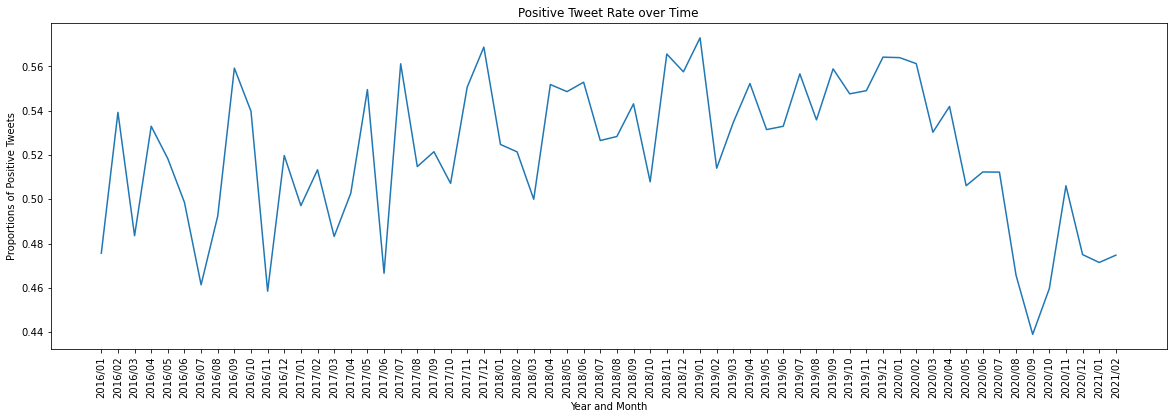

In [30]:
#Line plot of Compound over months and years
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(20,6))

sns.lineplot(x="year_month", y="count", estimator="mean", data=tweets_by_month, ax=ax)
plt.xticks(rotation=90)
ax.set_ylabel('Proportions of Positive Tweets')
ax.set_xlabel('Year and Month')

plt.title('Positive Tweet Rate over Time')
plt.show()

# Character and Player breakdown
The other main question we were pondering was how Positive Tweet rates differ by character choice. We come across a sample size issue since some characters are much rarer than others. Also, the only Yoshi player in the Top 100 is Japanese and VADER is only trained to handle English. 

As is though, among characters with multiple players, Ice Climbers rank the most positive and Sheik the least. This matches my intuition; Ice Climber players are generally considered nice people despite their character being reviled and Sheik players, who I am one of, do have an image of being complainers.

In the future, I may expand on this project by sampling from the larger Melee community on Twitter. This would involve creating a survey for users to submit their Twitter usernames and character choice. This would likely address the sample size issue for some characters.

In [46]:
#Joining the scraped Tweets with the character choices from our community spreadsheet
all_tweets_with_char = pd.merge(all_tweets, players, left_on= 'Username', right_on= 'Twitter', how = 'left')

#Creating a group by main
tweets_by_main = all_tweets_with_char.groupby('Main')['class'].value_counts(normalize=True).rename('count').reset_index()
tweets_by_main = tweets_by_main[tweets_by_main['class'] == 'positive']
tweets_by_main = tweets_by_main.sort_values(by='count', ascending = False)

#Tracking how many unique players of each characters there are
unique_mains = all_tweets_with_char.groupby('Main')['Username'].agg(['nunique'])

#Combining our Groupbys to create our final 
tweets_by_main_final = pd.merge(tweets_by_main, unique_mains, on=  'Main', how = 'left')
tweets_by_main_final.rename(columns = {'nunique':'Players', 'count':'Positive Rate'}, inplace = True) 
tweets_by_main_final.drop('class', axis=1, inplace = True)

tweets_by_main_final

,Main,Positive Rate,Players
0,Pikachu,0.680000,1
1,Ice Climbers,0.605315,5
2,Samus,0.582000,2
3,Ganon,0.569000,1
4,Peach,0.554885,8
5,Falco,0.547284,11
6,Marth,0.540195,13
7,Fox,0.529826,21
8,Captain Falcon,0.515450,8
9,Jigglypuff,0.510784,4
